# Assignment 2

* In this assignment, we will train a CNN Autoencoder with DX, dental and all-MIAS dataset.
* The result should be compared with conventional denoised methods.
* Comparisons are based on structural similarity index measure(SSIM) instead of peak signal to noise ratio (PSNR) for its consistency and accuracy.

# Environment
Use the following lines to import any needed libraries:

In [1]:
import os
import re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import matplotlib.pyplot as plt

# You may reference to these links below
# Tensorflow api: https://www.tensorflow.org/api_docs/python/tf/keras
# Skimage api: https://scikit-image.org/docs/stable/api/api.html

# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# from skimage.restoration import denoise_nl_means, estimate_sigma
# from skimage.metrics import structural_similarity as ssim
# from scipy import ndimage

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import structural_similarity as ssim
from scipy import ndimage

# Utilities

In [2]:
def read_pgm(filename):
    
    """Return image data from a raw PGM file as numpy array.
    Format specification: 
        http://netpbm.sourceforge.net/doc/pgm.html
        https://zh.wikipedia.org/wiki/PBM%E6%A0%BC%E5%BC%8F
    
    Parameters: 
        filename: Specify filename
    Returns:
        np.ndarray[int, int]): 2-D Image array expected each of shape [H, W] 
    """
    
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
#         print('Header:{}\nWidth:{}\nHeight:{}\nMaxval:{}'.format(header, width, height, maxval))
#         print('len {}'.format(len(header)))
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1',
                            count=int(width) * int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

In [3]:
def show_image(array, random = False):
    
    """Show 10 2-D image from 3-D array 

    Parameters:
        array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        random(bool): Flag determines show image following by index sequence or not.

    """
    n = 10
    if random == True:
        indices = np.random.randint(len(array), size=n)
    else:
        indices = np.arange(n)
    images = array[indices, :]
    fig, axes = plt.subplots(2, 5, figsize=(15,5))
    for i in range(2):
        for j in range(5):
            image = images[i*5+j, :, :]
            axes[i, j].set_title("Index = {}".format(indices[i*5+j]))
            axes[i, j].axis("off")
            axes[i, j].imshow(images[i*5+j].reshape(array.shape[1], array.shape[2]), cmap='gray')
    plt.show()

In [4]:
def read_dental(folder="./data/dental/"):
    images = []
    for filename in sorted(os.listdir(folder), key=lambda x : int(x.split('.')[0])):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

def read_mini_mias(folder="./data/all-mias/"):
    images = np.zeros((322, 1024, 1024))
    i = 0
    for dirName, subdirList, fileList in os.walk(folder):
        for fname in fileList:
            if fname.endswith(".pgm"):
                images[i] = read_pgm(folder + fname)
                i += 1
    return images

def read_dx(folder="data/DX/"):
    images = []
    for filename in sorted(os.listdir(folder), key=lambda x : int(x.split('.')[0])):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images)

def load_datasets(img_width=64, img_height=64):
    
    """Load datasets with image resize

    Parameters:
        img_width(int): Resize image with img_width
        img_height(int): Resize image with img_height
    Returns:
        mias_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
        dx_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
        dental_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
    """
    
    
    # Read mias dataset
    raw_mias = read_mini_mias()

    mias_images = np.zeros((raw_mias.shape[0], img_width, img_height))
    for i in range(raw_mias.shape[0]):
        mias_images[i] = cv2.resize(raw_mias[i], dsize=(img_width, img_height),
                                    interpolation=cv2.INTER_AREA)
    # Read dental dataset
    raw_dental = read_dental()  
    dental_images = np.zeros((raw_dental.shape[0], img_width, img_width))
    for i in range(raw_dental.shape[0]):
        dental_images[i] = cv2.resize(raw_dental[i], dsize=(img_width, img_height),
                                      interpolation=cv2.INTER_AREA)
    # Read DX dataset
    raw_dx = read_dx()
    dx_images = np.zeros((raw_dx.shape[0], img_width, img_width))
    for i in range(raw_dx.shape[0]):
        dx_images[i] = cv2.resize(raw_dx[i], dsize=(img_width, img_height),
                                  interpolation=cv2.INTER_AREA)
    
    return mias_images, dx_images, dental_images

In [5]:
def add_noise(array):
 
    """Adds random Guassian noise to each image in the supplied array.

    Parameters:
        array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
    Returns:
        noisy_array(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W] 
        
    """
    
    noise_factor = 0.5
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

In [6]:
def train_test_split(mias_images, dx_images, dental_images, train_split=0.9, img_height=64, img_width=64):
    
    """Combine datasets and split data into training and testing sets.

    Parameters:
        mias_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        dx_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        dental_images(np.ndarray[int, int, int]): 3-D Image array expected each of shape [N, H, W]
        train_split(float): Proportion of the dataset to include in the training sets
        img_height(int): Height of image
        img_width(int): Width of image
        
    Returns:
        imageset_train(np.ndarray[int, int, int, int]): Training sets, shape [N, H, W, C]
        imageset_test(np.ndarray[int, int, int, int]): Testing sets, shape [N, H, W, C]
    """
    
    imageset_train = mias_images[:int(mias_images.shape[0] * train_split)]
    imageset_train = np.append(imageset_train, dx_images[:int(dx_images.shape[0] * train_split)], axis=0)
    imageset_train = np.append(imageset_train, dental_images[:int(dental_images.shape[0] * train_split)], axis=0)
    
    imageset_test = mias_images[int(mias_images.shape[0] * train_split):]
    imageset_test = np.append(imageset_test, dx_images[int(dx_images.shape[0] * train_split):], axis=0)
    imageset_test = np.append(imageset_test, dental_images[int(dental_images.shape[0] * train_split):], axis=0)

    np.random.shuffle(imageset_train)
    
    imageset_train = imageset_train.reshape(imageset_train.shape[0], img_height, img_width, 1)
    imageset_test = imageset_test.reshape(imageset_test.shape[0], img_height, img_width, 1)
    
    return imageset_train, imageset_test

# Data

Load the datasets and display

MIAS dataset


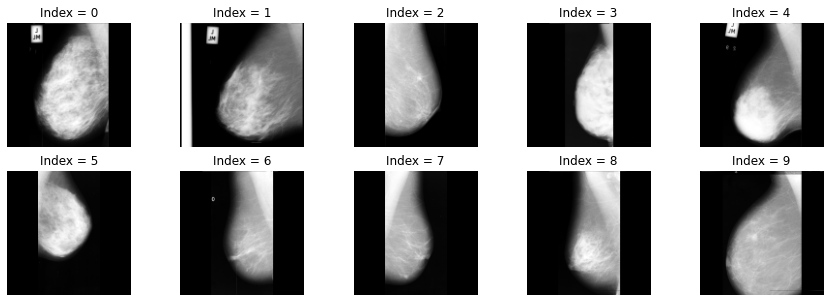

Dental X-ray dataset


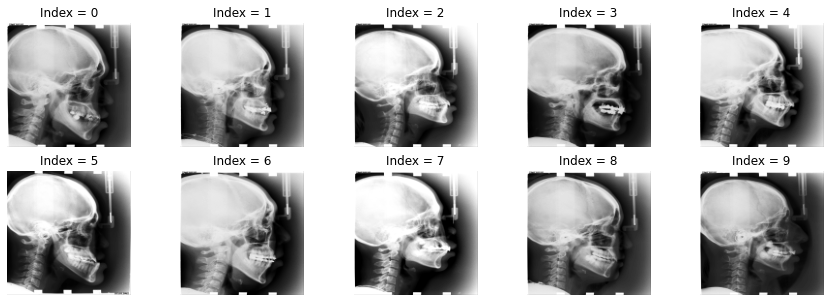

Dental Periapical X-Ray dataset


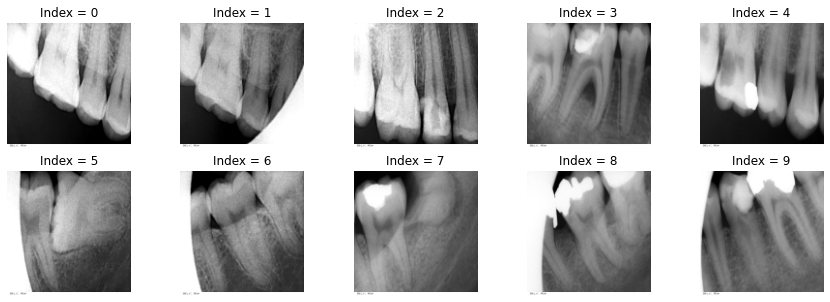

In [7]:
img_width = 128
img_height = 128
mias_images, dx_images, dental_images = load_datasets(img_width, img_height)
print('MIAS dataset')
show_image(mias_images)
print('Dental X-ray dataset')
show_image(dx_images)
print('Dental Periapical X-Ray dataset')
show_image(dental_images)

# Training

## Define the model

In [ ]:
def build_model(img_width=64, img_height=64):
    
    """Build customized model 

    Parameters:
        img_width(int): Specify input image shape
        img_height(int): Specify input image shape
    Returns:
        model

    """
    autoencoder = keras.Sequential()
    # Encoder
    autoencoder.add(keras.Input(shape=(img_width, img_height, 1)))
    autoencoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    autoencoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    # Decoder
    autoencoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.UpSampling2D((2, 2)))
    autoencoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    autoencoder.add(layers.UpSampling2D((2, 2)))
    autoencoder.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    autoencoder.summary()
    return autoencoder

In [ ]:
model = build_model(img_width, img_height)

## Splitting dataset

In [8]:
input_train, input_test = train_test_split(mias_images, dx_images, dental_images, 0.9, img_height, img_width)

In [9]:
input_train.shape

(757, 128, 128, 1)

In [10]:
input_test.shape

(85, 128, 128, 1)

Input image


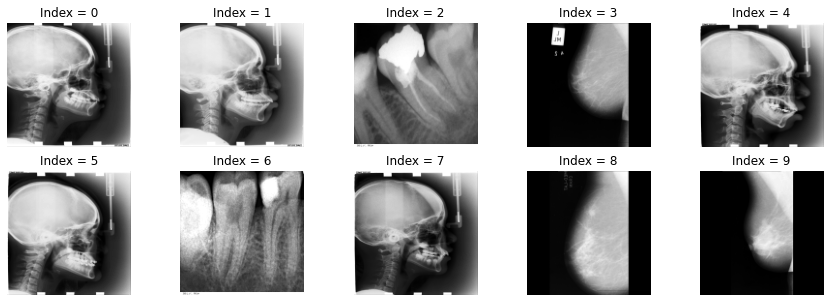

In [11]:
print("Input image")
show_image(input_train)

## Prepare data
* Scale images to the [0, 1] range
* Add noise

In [ ]:
# Scale images to the [0, 1] range
input_train = input_train.astype("float32") / 255
input_test = input_test.astype("float32") / 255
noisy_train = add_noise(input_train)
noisy_test = add_noise(input_test)

In [ ]:
print("Noisy image")
show_image(noisy_train)

## Model fitting with dataset

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=5)

hist = model.fit(
    noisy_train,
    input_train,
    epochs = 50,
    batch_size = 10,
    shuffle = True,
    validation_split = 0.1,
    verbose = 1,
    callbacks=[es]
)

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = len(loss)
plt.plot(range(epochs), loss, marker='.', label='train_loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## Evaluation

In [ ]:
denoised_images = model.predict(noisy_test)
print('Noisy test image')
show_image(noisy_test)
print('Denoised test image')
show_image(denoised_images)

In [ ]:
def plot_samples(input_test, noisy_test, denoised_images, numofrow=4, img_width=64, img_height=64):
    fig, axes = plt.subplots(numofrow, 5, figsize=(15,5*numofrow/2))

    indices = np.random.randint(len(input_test), size=numofrow)
    
    # Set axes titles
    axes[0][0].set_title('Original image')
    axes[0][1].set_title('Noisy image')
    axes[0][2].set_title('Autoencoder')
    axes[0][3].set_title('Median filter')
    axes[0][4].set_title('NLMeans filter')
    
    # Plot denoised images
    noisy_images = []
    pure_images = []
    autoencode_images = []
    median_images = []
    nlm_images = []
    
    for i in range(0, len(input_test)):
        # Get the sample and the reconstruction
        noisy_image = noisy_test[i][:, :, 0]
        pure_image = input_test[i][:, :, 0]
        denoised_image = denoised_images[i][:, :, 0]
        median_image = apply_median_filter(noisy_test[i].reshape(img_height, img_width))
        nlm_denoised = apply_nlm_filter(noisy_test[i].reshape(img_height, img_width))
        noisy_images.append(noisy_image)
        pure_images.append(pure_image)
        autoencode_images.append(denoised_image)
        median_images.append(median_image)
        nlm_images.append(nlm_denoised)

    noisy_images = np.array(noisy_images)
    pure_images = np.array(pure_images)
    autoencode_images = np.array(autoencode_images)
    median_images = np.array(median_images)
    nlm_images = np.array(nlm_images)    
    
    print("SSIM result:\nNoisy:{:.5f}, Autoencoder:{:.5f}, Median:{:.5f}, NLMeans:{:.5f}"
          .format(calculate_set_ssim(pure_images, noisy_images, img_width, img_height),
                  calculate_set_ssim(pure_images, denoised_images, img_width, img_height),
                  calculate_set_ssim(pure_images, median_images, img_width, img_height),
                  calculate_set_ssim(pure_images, nlm_images, img_width, img_height)))
    for i in range(0, numofrow):
        # Plot sample and reconstruction
        noisy_image = noisy_images[indices[i]]
        pure_image = pure_images[indices[i]]
        denoised_image = autoencode_images[indices[i]]
        median_image = median_images[indices[i]]
        nlm_denoised = nlm_images[indices[i]]
        axes[i][0].imshow(pure_image, plt.cm.gray)
        axes[i][0].set_ylabel("SSIM: {:.5f}".format(calculate_image_ssim(pure_image, pure_image)))
        axes[i][1].imshow(noisy_image, plt.cm.gray)
        axes[i][1].set_ylabel("SSIM: {:.5f}".format(calculate_image_ssim(pure_image, noisy_image)))
        axes[i][2].imshow(denoised_image, plt.cm.gray)
        axes[i][2].set_ylabel("SSIM: {:.5f}".format(calculate_image_ssim(pure_image, denoised_image)))
        axes[i][3].imshow(median_image, plt.cm.gray)
        axes[i][3].set_ylabel("SSIM: {:.5f}".format(calculate_image_ssim(pure_image, median_image)))
        axes[i][4].imshow(nlm_denoised, plt.cm.gray)
        axes[i][4].set_ylabel("SSIM: {:.5f}".format(calculate_image_ssim(pure_image, nlm_denoised)))
    plt.show() 
    
def apply_median_filter(image, kernel_size = 5):
#     print("Image denoised using Mean filter")
    return ndimage.median_filter(image, size=kernel_size)
def apply_nlm_filter(image):
#     print("Image denoised using NL Means")
    sigma_est = np.mean(estimate_sigma(image, multichannel=False))
    denoised_image = denoise_nl_means(image, h=1.*sigma_est)
    return denoised_image
def calculate_image_ssim(original_img, noisy_img):
    return ssim(original_img, noisy_img, data_range=noisy_img.max() - noisy_img.min())
def calculate_set_ssim(originalSet, noisySet, img_width=64, img_height=64):
    ssim_sum = 0
    originalSet = originalSet.reshape(originalSet.shape[0], img_height, img_width)
    noisySet = noisySet.reshape(noisySet.shape[0], img_height, img_width)
    for i in range(originalSet.shape[0]):
        ssim_sum += ssim(originalSet[i], noisySet[i], data_range=noisySet[i].max() - noisySet[i].min())
    return ssim_sum/originalSet.shape[0]

In [ ]:
plot_samples(input_test, noisy_test, denoised_images, 4, img_width, img_height)